In [1]:
# How to train your network using transfer learning ?
# CS231n notes:
    # In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size.
    # Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.
# Two major transfer learning scenerios : 
    # Finetuning the Convnet: instead of random initialization, we initialize the network with a pretrained network and rest of the training is usual.
    # Convnet as fixed feature extractor : we freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Load Data
# using torchvision and torch.utils.data packages for loading data.
# The dataset has 120 training images and 75 validation images for each of the two classes(bees and ants).
# usually, it is a very small dataset to genralize upon, if trained from scratch. since we are using transfer learning, we should be be able to generalize reasonably well.

# Data augmentation/pre-processing and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

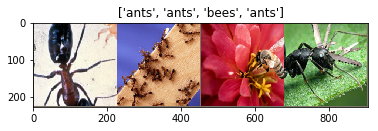

In [4]:
# Visualize a few images
def imshow(inp, title=None):
    inp = inp.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)    # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# Training the model
    # Scheduling the learning rate
    # Saving the best model
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()    # Set model to training mode
            else:
                model.eval()     # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history only if train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds == labels.data)
                
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
# Visualizing the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far+=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
# Finetuning the convnet
    # load a pretrained model and reset final fully connected layer

model_ft = models.resnet18(pretrained=True)
num_fltrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fltrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [8]:
# Train and Evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7446 Acc: 0.6557
val Loss: 0.2173 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5360 Acc: 0.7787
val Loss: 0.3206 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5502 Acc: 0.7664
val Loss: 0.3250 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4999 Acc: 0.7951
val Loss: 0.5627 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.5004 Acc: 0.8361
val Loss: 0.3416 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4535 Acc: 0.8361
val Loss: 0.6615 Acc: 0.8039

Epoch 6/24
----------
train Loss: 0.6653 Acc: 0.7746
val Loss: 0.5560 Acc: 0.8170

Epoch 7/24
----------
train Loss: 0.3944 Acc: 0.8443
val Loss: 0.2722 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2990 Acc: 0.8770
val Loss: 0.2709 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3799 Acc: 0.8402
val Loss: 0.2587 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.4145 Acc: 0.8033
val Loss: 0.3036 Acc: 0.8824

Epoch 11/24
----------
train Loss: 0.2759 Acc: 0.8852
val Loss: 0.2829 Acc: 0.8889

Ep

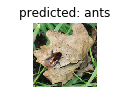

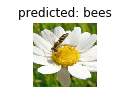

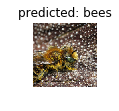

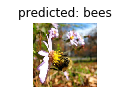

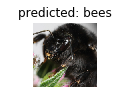

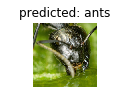

In [9]:
visualize_model(model_ft)
plt.ioff()
plt.show()

In [10]:
# Convnet as a fixed feature extractor
# we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters
# so that the gradients are not computed in backward().

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_fltrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_fltrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_sceduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
# Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6398 Acc: 0.6434
val Loss: 0.2750 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5997 Acc: 0.7213
val Loss: 0.2099 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5868 Acc: 0.7459
val Loss: 0.1788 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3892 Acc: 0.8156
val Loss: 0.2024 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4004 Acc: 0.7992
val Loss: 0.1797 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3936 Acc: 0.8197
val Loss: 0.1851 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3605 Acc: 0.8484
val Loss: 0.2806 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.4267 Acc: 0.8033
val Loss: 0.2044 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4328 Acc: 0.8361
val Loss: 0.2480 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3273 Acc: 0.8525
val Loss: 0.1767 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.6941 Acc: 0.7664
val Loss: 0.1857 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.5178 Acc: 0.7623
val Loss: 0.2672 Acc: 0.9150

Ep

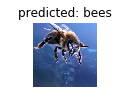

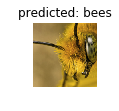

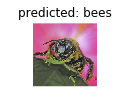

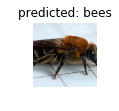

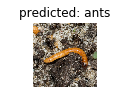

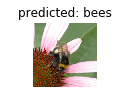

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()